In [1]:
%config InlineBackend.figure_formats = ['svg']
import matplotlib.pyplot as plt
import matplotlib
matplotlib.pyplot.rc('text', usetex=True)

# Obtain the fasta file for PhiX

In [2]:
!wget http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/phix.fa


--2025-03-26 18:49:14--  http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/phix.fa
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 18.155.188.60, 18.155.188.175, 18.155.188.167, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|18.155.188.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5528 (5.4K) [application/octet-stream]
Saving to: ‘phix.fa’

phix.fa             100%[===================>]   5.40K  --.-KB/s    in 0.001s  

2025-03-26 18:49:15 (3.70 MB/s) - ‘phix.fa’ saved [5528/5528]



In [3]:
def readGenome(filename):
    genome = ''
    with open(filename, 'r') as f:
        for line in f:
            # ignore header line with genome information
            if not line[0] == '>':
                genome += line.rstrip()
    return genome

genome = readGenome('phix.fa')

In [5]:
# Alternatively we can also do this

def readGenome(filename):
    with open(filename, 'r') as f:
        return ''.join(line.strip() for line in f if not line.startswith('>'))

genome = readGenome('phix.fa')


#### Create a matching algorithm that takes two arguments, P and T where:
##### P = the pattern we are searching for
##### T = the place we are searching in

In [6]:
def naive(p, t):
    occurrences = []
    for i in range(len(t) - len(p) + 1):
        match = True
        for j in range(len(p)):
            if t[i+j] != p[j]:
                match = False
                break
        if match:
          occurrences.append(i)
    return occurrences

In [7]:
t = 'AGCTTAGATGCATTTTTAGC'
p = 'TTA'
naive(p, t)

[3, 15]

In [8]:
# Again we can do the block below to accomplish the same task

def naive(p, t):
    occurrences = []
    m, n = len(p), len(t)
    for i in range(n - m + 1):
        if t[i:i + m] == p:
            occurrences.append(i)
    return occurrences

In [9]:
t = 'AGCTTAGATGCATTTTTAGC'
p = 'TTA'
naive(p, t)

[3, 15]

### Generate random reads from the genome

In [15]:
import random
def generateReads1(genome, numReads, readLen):
    ''' Generate reads from random positions in the given genome. '''
    reads = []
    for _ in range(numReads):
        start = random.randint(0, len(genome)-readLen) - 1
        reads.append(genome[start : start+readLen])
    return reads

In [16]:
# Generate 100 reads of length 100
reads = generateReads1(genome, 100, 100)

# Count how many reads match the genome exactly
numMatched = 0
for r in reads:
    matches = naive(r, genome)
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome exactly!' % (numMatched, len(reads)))

100 / 100 reads matched the genome exactly!


In [17]:
# We can accomplish the same by doing the following as well

import random

def generateReads2(genome, numReads, readLen):
    '''Generate reads from random positions in the given genome.'''
    max_start = len(genome) - readLen
    return [genome[(s := random.randint(0, max_start)) : s + readLen] for _ in range(numReads)]


In [18]:
# Generate 100 reads of length 100
reads = generateReads2(genome, 100, 100)

# Count how many reads match the genome exactly
numMatched = 0
for r in reads:
    matches = naive(r, genome)
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome exactly!' % (numMatched, len(reads)))

100 / 100 reads matched the genome exactly!


# Download an actual sequence

In [19]:
!wget http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR266411_1.first1000.fastq

--2025-03-26 19:03:01--  http://d28rh4a8wq0iu5.cloudfront.net/ads1/data/ERR266411_1.first1000.fastq
Resolving d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)... 18.155.188.170, 18.155.188.167, 18.155.188.175, ...
Connecting to d28rh4a8wq0iu5.cloudfront.net (d28rh4a8wq0iu5.cloudfront.net)|18.155.188.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 254384 (248K) [audio/mpeg]
Saving to: ‘ERR266411_1.first1000.fastq’

ERR266411_1.first10 100%[===================>] 248.42K  1.56MB/s    in 0.2s    

2025-03-26 19:03:01 (1.56 MB/s) - ‘ERR266411_1.first1000.fastq’ saved [254384/254384]



In [28]:
def readFastq(filename):
    sequences = []
    with open(filename) as fh:
        while True:
            fh.readline() # skip name line
            seq = fh.readline().rstrip() # read base sequence
            fh.readline() # skip placeholder line
            fh.readline() # skip base quality line
            if len(seq) == 0:
                break
            sequences.append(seq)
    return sequences

In [29]:
import collections
phix_reads = readFastq('ERR266411_1.first1000.fastq')
count = collections.Counter()
for read in phix_reads:
    count.update(read)
count

Counter({'T': 30531, 'A': 28426, 'C': 21890, 'G': 19147, 'N': 6})

In [30]:
numMatched = 0
n = 0
for r in phix_reads:
    matches = naive(r, genome)
    n += 1
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome exactly!' % (numMatched, n))

7 / 1000 reads matched the genome exactly!


In [31]:
# Now let's try matching just the first 30 bases of each read
numMatched = 0
n = 0
for r in phix_reads:
    r = r[:30]  # just taking the first 30 bases
    matches = naive(r, genome)
    n += 1
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome exactly!' % (numMatched, n))

459 / 1000 reads matched the genome exactly!


In [32]:
def reverseComplement(s):
    table = str.maketrans('ACGT', 'TGCA')
    return s[::-1].translate(table)

In [33]:
numMatched = 0
n = 0
for r in phix_reads:
    r = r[:30]  # just taking the first 30 bases
    matches = naive(r, genome)
    matches.extend(naive(reverseComplement(r), genome))
    n += 1
    if len(matches) > 0:
        numMatched += 1
print('%d / %d reads matched the genome exactly!' % (numMatched, n))

932 / 1000 reads matched the genome exactly!


In [34]:
# Alternatively we can do the following

n = 0
numMatched = 0

for r in phix_reads:
    r30 = r[:30]  # take only the first 30 bases
    # Check for forward match; if none, then check reverse complement.
    if naive(r30, genome) or naive(reverseComplement(r30), genome):
        numMatched += 1
    n += 1

print(f'{numMatched} / {n} reads matched the genome exactly!')


932 / 1000 reads matched the genome exactly!


# Below is an example that collects the start positions of all matches and then plots a histogram showing which regions of the genome have matching reads:


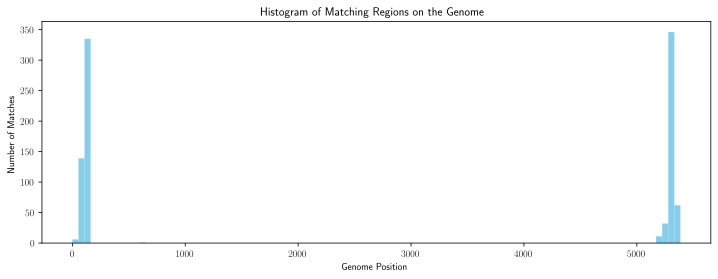

In [35]:
import matplotlib.pyplot as plt

# Collect match positions
match_positions = []
for r in phix_reads:
    r30 = r[:30]
    forward_matches = naive(r30, genome)
    reverse_matches = naive(reverseComplement(r30), genome)
    # Combine all match positions for this read
    match_positions.extend(forward_matches + reverse_matches)

# Plot a histogram of match positions along the genome
plt.figure(figsize=(12, 4))
plt.hist(match_positions, bins=100, range=(0, len(genome)), color='skyblue')
plt.xlabel('Genome Position')
plt.ylabel('Number of Matches')
plt.title('Histogram of Matching Regions on the Genome')
plt.show()